## Building a Neural Network From Scratch Using Python
this tutorial is based on: https://heartbeat.fritz.ai/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432


---
# Mounting of Google Drive
---
Linking the Google Drive to Google CoLab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
CourseFolder = "/content/gdrive/MyDrive/Crafting/BDLCV"

In this tutorial, you’re are going to create a neural network that predicts if a person will have heart disease or not. You’ll use a heart disease dataset from the UCL data repository.

```Pandas``` is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool. We use pandas to assist us to effectively read the data file.

In [ ]:
import csv
import pandas as pd

# add header names
headers =  ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']

heart_df = pd.read_csv(CourseFolder+'/Day 2/heart.dat', sep=' ', names=headers)

It has 13 features for the input and one label for output. The 13 features are all float64 and the label is a int64.

In [ ]:
heart_df.dtypes

age                        float64
sex                        float64
chest_pain                 float64
resting_blood_pressure     float64
serum_cholestoral          float64
fasting_blood_sugar        float64
resting_ecg_results        float64
max_heart_rate_achieved    float64
exercise_induced_angina    float64
oldpeak                    float64
slope of the peak          float64
num_of_major_vessels       float64
thal                       float64
heart_disease                int64
dtype: object

The data is being pre-processed to be in a format suitable for nueral network. 

The input values are being standardized with a mean value of 0 and standard deviation of 1. 

The output values are replaced with '0' for no heart disease and '1' for having heart disease.

In [ ]:
import warnings
warnings.filterwarnings("ignore") #suppress warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#convert imput to numpy arrays
X = heart_df.drop(columns=['heart_disease'])

#replace target class with 0 and 1 
#1 means "have heart disease" and 0 means "do not have heart disease"
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1, 0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2, 1)

y_label = heart_df['heart_disease'].values.reshape(X.shape[0], 1)

#split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


The data is also split into Train-Test set. 80% (216 records) will be used to train the model while 20% (54 records) will be used for testing the model.

---
Now lets begin the coding of the Neural Network.

First we import the libraries.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Define a function to initialze the layer numbers, learning rate and interations.

In [ ]:
def initialize(_layers=[13,8,1], _learning_rate=0.001, _iterations=100):
  global params, learning_rate, iterations, loss, sample_size, layers, X, y

  learning_rate = _learning_rate
  iterations = _iterations
  layers = _layers
  params = {}
  loss = []
  sample_size = None
  layers = None
  X = None
  y = None

  np.random.seed(1) # Seed the random number generator
  params["W1"] = np.random.randn(_layers[0], _layers[1]) 
  params['b1'] = np.random.randn(_layers[1],)
  params['W2'] = np.random.randn(_layers[1],_layers[2]) 
  params['b2'] = np.random.randn(_layers[2],)

Define all the activation functions needed, including Relu and Sigmoid. We also define the First Derivative of Relu which is needed in the Backpropagation algorithm.

In [ ]:
def relu(Z):
  return np.maximum(0,Z)

def dRelu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

def sigmoid(Z):
  return 1/(1+np.exp(-Z))


Define the Loss function. As this is a Binary Classification problem. The Loss function is the Binary Cross Entropy

In [ ]:
def eta(x):
  ETA = 0.0000000001
  return np.maximum(x, ETA)

def entropy_loss(y, yhat):
  nsample = len(y)
  yhat_inv = 1.0 - yhat
  y_inv = 1.0 - y
  yhat = eta(yhat) ## clips value to avoid NaNs in log
  yhat_inv = eta(yhat_inv) 
  loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
  return loss

Define the function to perform the feed forward calculation. The loss is calcualted at the same time.

In [ ]:
def forward_propagation():
  global params, learning_rate, iterations, loss, sample_size, layers, X, y

  Z1 = X.dot(params['W1']) + params['b1']
  A1 = relu(Z1)
  Z2 = A1.dot(params['W2']) + params['b2']
  yhat = sigmoid(Z2)
  yloss = entropy_loss(y,yhat)

  # save calculated parameters     
  params['Z1'] = Z1
  params['Z2'] = Z2
  params['A1'] = A1

  return yhat,yloss    

Define the function to perform the back propagation algorithm.

In [ ]:
def back_propagation(yhat):
  global params, learning_rate, iterations, loss, sample_size, layers, X, y

  y_inv = 1 - y
  yhat_inv = 1 - yhat

  dl_wrt_yhat = np.divide(y_inv, eta(yhat_inv)) - np.divide(y, eta(yhat))
  dl_wrt_sig = yhat * (yhat_inv)
  dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

  dl_wrt_A1 = dl_wrt_z2.dot(params['W2'].T)
  dl_wrt_w2 = params['A1'].T.dot(dl_wrt_z2)
  dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

  dl_wrt_z1 = dl_wrt_A1 * dRelu(params['Z1'])
  dl_wrt_w1 = X.T.dot(dl_wrt_z1)
  dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

  #update the weights and bias
  params['W1'] = params['W1'] - learning_rate * dl_wrt_w1
  params['W2'] = params['W2'] - learning_rate * dl_wrt_w2
  params['b1'] = params['b1'] - learning_rate * dl_wrt_b1
  params['b2'] = params['b2'] - learning_rate * dl_wrt_b2

Define the function to fit (train) the model.

In [ ]:
def fit(_X, _y):
  global params, learning_rate, iterations, loss, sample_size, layers, X, y

  X = _X
  y = _y

  for i in range(iterations):
    yhat, yloss = forward_propagation()
    back_propagation(yhat)
    loss.append(yloss)

Define the function to plot the loss curve of the training.

In [ ]:
def plot_loss():
  plt.plot(loss)
  plt.xlabel("Iteration")
  plt.ylabel("logloss")
  plt.title("Loss curve for training")
  plt.show()  

We are now ready to train the model.

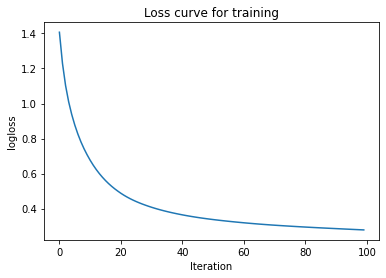

In [ ]:
initialize()
fit(Xtrain, ytrain)
plot_loss()

We can make use of the train model to make prediction using the test dataset.

First we define a function to make prediction and one function to calculate the accuracy of the prediction.

In [ ]:
def predict(_X):
  global params, learning_rate, iterations, loss, sample_size, layers, X, y

  Z1 = _X.dot(params['W1']) + params['b1']
  A1 = relu(Z1)
  Z2 = A1.dot(params['W2']) + params['b2']
  pred = sigmoid(Z2)
  return np.round(pred) 

def acc(y, yhat):
  acc = int(sum(y == yhat) / len(y) * 100)
  return acc

Now make the prediction.

In [ ]:
train_pred = predict(Xtrain)
test_pred = predict(Xtest)

print("Train accuracy is {}%".format(acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(acc(ytest, test_pred)))

Train accuracy is 87%
Test accuracy is 75%


---
## Creating a better model
---

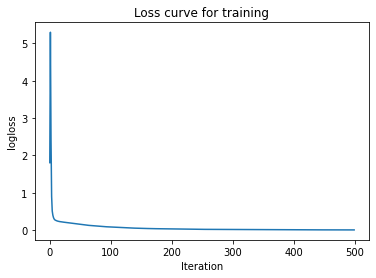

In [ ]:
initialize(_layers=[13,10,1], _learning_rate=0.01, _iterations=500) # create the NN model
fit(Xtrain, ytrain)
plot_loss()

In [ ]:
train_pred = predict(Xtrain)
test_pred = predict(Xtest)

print("Train accuracy is {}%".format(acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(acc(ytest, test_pred)))

Train accuracy is 100%
Test accuracy is 70%
